https://gist.github.com/bsweger/e5817488d161f37dcbd2

http://stackoverflow.com/questions/20250689/plotting-a-large-number-of-points-using-matplotlib-and-running-out-of-memory

http://stackoverflow.com/questions/19092812/measure-max-memory-usage-with-ipython-like-timeit-but-memit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib notebook
%matplotlib inline 
plt.style.use('seaborn-bright')

import pickle
from IPython.display import display

%load_ext memory_profiler

In [25]:
%%time 
%%memit pass

# custom groupby
df = pd.DataFrame({'k': [1,1,2,2,3,3,3], 'v': [10,20,40,30,10,11,12], 'type':[0,0,0,2,0,2,2]})
df.index = df.k
df = df.drop('k',1)

def myf(df):
    temp_df = df.loc[df['type'] == 2]
    if temp_df.empty:
        return df.iloc[0] # [0:1]
    else:
        return temp_df.iloc[0]

df = df.groupby(df.index).apply(myf) 

display(df)

,type,v
k,,
1,0,10
2,2,30
3,2,11


,type,v
k,,
1,0,10
2,2,30
3,2,11


peak memory: 72.09 MiB, increment: 1.43 MiB
CPU times: user 124 ms, sys: 202 ms, total: 325 ms
Wall time: 527 ms


In [26]:
# merge, sql join on multiple columns

df = pd.DataFrame({'k': [1,1,2,2,3,3,3], 'size': [10,20,40,30,1,1,10], 'type':[0,0,0,2,0,2,2], 'price': [1.0,2.0,4.0,3.0,1.0,1.1,10]})
display(df)

df2 = pd.DataFrame({'kp': [1,2,3,4], 'typep':[2,2,2,2],'name': ['A','B','C','D']})
display(df2)

df.merge(df2, left_on=['k','type'], right_on=['kp','typep'], how='left')

,k,price,size,type
0,1,1.0,10,0
1,1,2.0,20,0
2,2,4.0,40,0
3,2,3.0,30,2
4,3,1.0,1,0
5,3,1.1,1,2
6,3,10.0,10,2


,kp,name,typep
0,1,A,2
1,2,B,2
2,3,C,2
3,4,D,2


,k,price,size,type,kp,name,typep
0,1,1.0,10,0,NaN,NaN,NaN
1,1,2.0,20,0,NaN,NaN,NaN
2,2,4.0,40,0,NaN,NaN,NaN
3,2,3.0,30,2,2.0,B,2.0
4,3,1.0,1,0,NaN,NaN,NaN
5,3,1.1,1,2,3.0,C,2.0
6,3,10.0,10,2,3.0,C,2.0


In [24]:
# show duplicated rows
df = pd.DataFrame({'k': [1,1,2,2,3,3,3], 'v': [10,20,40,30,10,11,12], 'type':[0,0,0,2,0,2,2]})
df.index = df.k
df = df.drop('k',1)

ind = df.duplicated(subset='v', keep=False)
df[ind]

,type,v
k,,
1,0,10
3,0,10


In [16]:
df = pd.DataFrame(np.arange(25).reshape(5,5), 
                      index=pd.date_range('1/1/2016', periods=5),
                      columns=list('ABCDE'))

df.rename(columns={'E': 'X'}, inplace=True)
df


,A,B,C,D,X
2016-01-01,0,1,2,3,4
2016-01-02,5,6,7,8,9
2016-01-03,10,11,12,13,14
2016-01-04,15,16,17,18,19
2016-01-05,20,21,22,23,24


In [3]:

with open('filename.pickle', 'wb') as fid:
    pickle.dump(df, fid)
    
with open('filename.pickle', 'rb') as fid:
    df = pickle.load(fid)

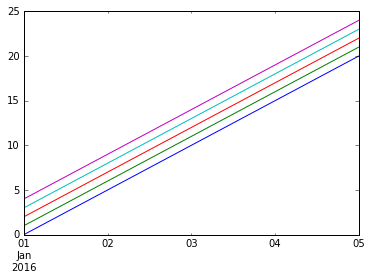

In [4]:
df.plot()
plt.legend().remove()


plot1
<bound method Axes.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x7f6f2cceccc0>>


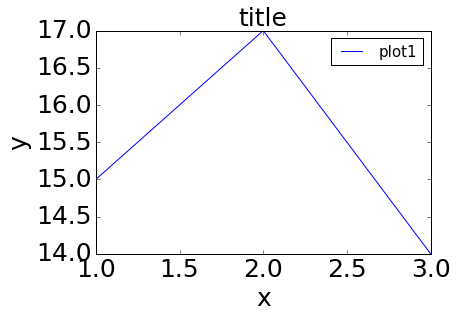

In [5]:
# http://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
x1 = [1,2,3]
y1 = [15,17,14]

h1, = plt.plot(x1,y1, label='plot1')
print(h1.get_label()) #unpacked to Line2D(plot1)

plt.xlabel('x')
plt.ylabel('y')
plt.title('title')
plt.legend(fontsize = 15)

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(25)
print(ax.legend)





In [6]:
def myf(num):
  return num, (num+10, num+20), (num*2, num*4, num*10)

result, *rest = myf(1)

rest

[(11, 21), (2, 4, 10)]

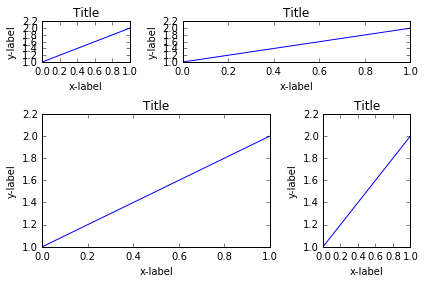

In [7]:
import matplotlib.pyplot as plt


def example_plot(ax):
    ax.plot([1, 2])
    ax.set_xlabel('x-label')
    ax.set_ylabel('y-label')
    ax.set_title('Title')


fig = plt.figure()

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
ax3 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4 = plt.subplot2grid((3, 3), (1, 2), rowspan=2)

example_plot(ax1)
example_plot(ax2)
example_plot(ax3)
example_plot(ax4)

plt.tight_layout()

                   A         B         C         D         E
2016-01-01  0.757646  0.699819  0.344087  0.355382  0.286086
2016-01-02  0.951842  0.743475  0.748973  0.072735  0.916901
2016-01-03  0.185560  0.488413  0.717834  0.269923  0.967536
2016-01-04  0.906705  0.344505  0.026215  0.202537  0.256815
2016-01-05  0.476185  0.310522  0.537668  0.843368  0.844292


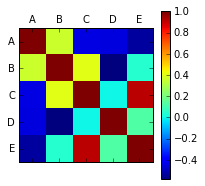

In [8]:
df = pd.DataFrame(np.random.rand(25).reshape(5,5), 
                      index=pd.date_range('1/1/2016', periods=5),
                      columns=list('ABCDE'))
print(df)
corr = df.corr()

fig, ax = plt.subplots(figsize=(3, 3))
h = ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

plt.colorbar(h)
plt.set_cmap('Greys')

In [9]:
t = np.linspace(1,27,27).reshape(3,3,3)
pan = pd.Panel(t)

print(pan)
print(type(pan.iloc[0,:,:]))
print(type(pan.iloc[0,0,:]))
print(type(pan.iloc[0,0,0]))

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 3 (major_axis) x 3 (minor_axis)
Items axis: 0 to 2
Major_axis axis: 0 to 2
Minor_axis axis: 0 to 2
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'numpy.float64'>


product              Gloves  Pants  Shoes
date       minor                         
2013-01-01 price       10.0   50.0  100.0
           quantity     5.0   10.0   10.0
2013-01-02 price       12.5   55.5  102.5
           quantity     6.0   12.0   10.0
2013-01-03 price       10.0   50.0  100.0
           quantity     7.0   14.0   12.0

product              Gloves  Pants  Shoes
date       minor                         
2013-01-01 price      -10.0  -50.0 -100.0
           quantity    -5.0  -10.0  -10.0
2013-01-02 price      -12.5  -55.5 -102.5
           quantity    -6.0  -12.0  -10.0
2013-01-03 price      -10.0  -50.0 -100.0
           quantity    -7.0  -14.0  -12.0

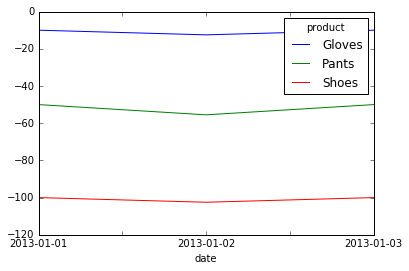

In [10]:
df = pd.read_csv('notes.csv', index_col=[0,1])

pan = df.to_panel()

pan = pan.swapaxes('minor','items')

display(pan.to_frame())

for column in pan.iloc[0].columns:
#     print(column)
    pan.loc[:,:,column] = - pan.loc[:,:,column]

display(pan.to_frame())

# Items axis: Gloves to Shoes
# Major_axis axis: 2013-01-01 to 2013-01-03
# Minor_axis axis: price to quantity


pan.loc[:,:,'price'].plot();

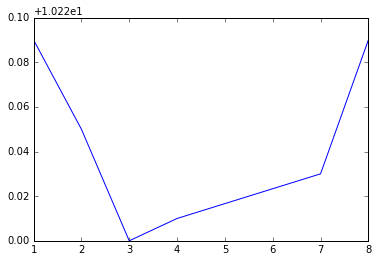

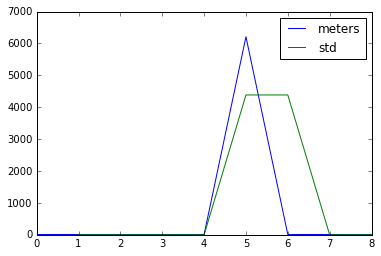

In [11]:
# example of removing outliers 
bridge_height = {'meters':[10.26, 10.31, 10.27, 10.22, 10.23, 6212.42, 10.28, 10.25, 10.31]}
df = pd.DataFrame(bridge_height)
df['std'] = df.rolling(window=2).std()
df_std=df.describe()['meters']['std']
df[df['std']<df_std]['meters'].plot()
df.plot()

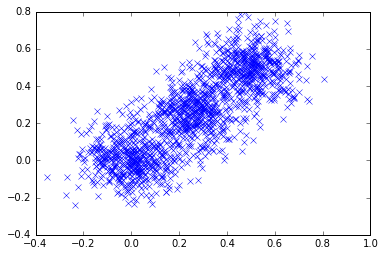

In [4]:
mu, sigma = 0, 0.1 # mean and standard deviation
x0 = np.random.normal(mu, sigma, 500)
y0 = np.random.normal(mu, sigma, 500)

mu, sigma = 0.25, 0.1 # mean and standard deviation
x1 = np.random.normal(mu, sigma, 500)
y1 = np.random.normal(mu, sigma, 500)

mu, sigma = 0.5, 0.1 # mean and standard deviation
x2 = np.random.normal(mu, sigma, 500)
y2 = np.random.normal(mu, sigma, 500)

x = np.concatenate((x0,x1,x2))
y = np.concatenate((y0,y1,y2))

fig, ax = plt.subplots()
ax.plot(x,y,'x')

In [5]:
# http://stackoverflow.com/questions/16626058/what-is-the-performance-impact-of-non-unique-indexes-in-pandas
x = np.random.randint(0, 200, 10**6)
df1 = pd.DataFrame({'x':x})
df2 = df1.set_index('x', drop=False)
df3 = df2.sort_index()
%timeit df1.ix[100]
%timeit df2.ix[100]
%timeit df3.ix[100]

The slowest run took 551.92 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 180 µs per loop
10 loops, best of 3: 32.4 ms per loop
The slowest run took 67.14 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 216 µs per loop


In [12]:
def whereami(df, ind, num_to_view=5):
    if not isinstance(df, pd.DataFrame):
        raise TypeError('must be pandas.core.frame.DataFrame')
    try:
        location = df.index.get_loc(str(ind))
    except KeyError:
         location = df.index.get_loc(ind)
            
    try: 
        new_location = slice(location.start-num_to_view, location.stop+num_to_view+1, location.step)
    except AttributeError:
        new_location = slice(location-num_to_view, location+num_to_view+1)
    return df[new_location]

tips = sns.load_dataset("tips")
whereami(tips,20,3)

,total_bill,tip,sex,smoker,day,time,size
17,16.29,3.71,Male,No,Sun,Dinner,3
18,16.97,3.50,Female,No,Sun,Dinner,3
19,20.65,3.35,Male,No,Sat,Dinner,3
20,17.92,4.08,Male,No,Sat,Dinner,2
21,20.29,2.75,Female,No,Sat,Dinner,2
22,15.77,2.23,Female,No,Sat,Dinner,2
23,39.42,7.58,Male,No,Sat,Dinner,4


peak memory: 129.04 MiB, increment: 53.76 MiB
CPU times: user 429 ms, sys: 269 ms, total: 697 ms
Wall time: 1.03 s


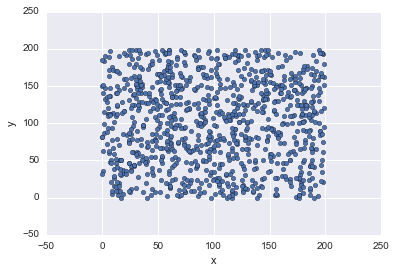

In [22]:
%%time 
%%memit pass
# down sampling in order to plot faster

x = np.random.randint(0, 200, 10**6)
y = np.random.randint(0, 200, 10**6)
df = pd.DataFrame({'x':x, 'y':y})
# df.shape # (1000000, 2)

df.sample(1000).plot(kind='scatter', x='x', y='y')

# without down sampling
# peak memory: 338.07 MiB, increment: 151.70 MiB
# CPU times: user 13.8 s, sys: 458 ms, total: 14.3 s
# Wall time: 14.3 s